In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openai import OpenAI
import base64
import requests
from dotenv import load_dotenv
import os
from pathlib import Path
import re
from SDAPI_utils import SDAPI
from PIL import Image
import numpy as np
from transformers import AutoProcessor, AutoTokenizer, CLIPModel

/work/sz206/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/work/sz206/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
import os
os.environ['no_proxy'] = '127.0.0.1,localhost'

In [4]:
load_dotenv()

True

In [5]:
# open_api_key = os.getenv("OPENAI_API_KEY")
# os.environ['http_proxy'] = os.getenv("HTTP_PROXY")
# os.environ['https_proxy'] = os.getenv("HTTPS_PROXY")

In [6]:
client = OpenAI(base_url="https://api.chatanywhere.com.cn/v1")

In [7]:
def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

In [8]:
def getDescFromGPTVis(img_files, client, diff=False):
    if diff:
        prompt = "Describe the differences of the second image from the first one in detail."
    else: prompt = "Craft a detailed description about the object in this image."
    content = [{"type": "text", "text": prompt}]
    for img in img_files:
        base64_image = encode_image(img)
        content.append({"type": "image_url",
                "image_url": { "url": f"data:image/jpeg;base64,{base64_image}"},})
    messages=[
    {
        "role": "user",
        "content": content,
    }
    ]
    response = client.chat.completions.create( model="gpt-4-turbo", messages=messages, max_tokens=500)
    return response

def reformPrompt(desc):
    return f"""Rephrase the following description using a number of short phrases. 
            Each phrase should consist of adjectives and a noun. Return only the answer without any leading or appending words:
            {desc}"""

# def combPrompt(orig_desc, diff_desc):
#     return f'''I aim to generate an image based on the textual description provided for a given image. 
#                 However, the resulting image may differ from the original one. The original description is: {orig_desc}. 
#                 The differences are: {diff_desc}, where the left one refers to the original image and the right one refers to the generated image.
#                 Please generate a more precise description about the original image by calibrating the original description based on the differences.'''

def combPrompt(orig_desc, diff_desc):
    # return f'''I aim to generate the second image based on the textual description about the first image. 
    #             However, the resulting second image may differ from the first one. The textual description is: {orig_desc}. 
    #             The differences are: {diff_desc}.
    #             Please calibrate the textual description about the first image based on these differences.'''
    return f'''Please refine the description of the first image, 
    taking into account the differences identified from the second image created based on this description.
    the original description is: "{orig_desc}", and the differences are:
    f"{diff_desc}.'''

def getDescFromGPTTxt(client, prompt, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
      ]
    )
    return response

def getPromtForSD(desc, extras=[]):
    desc = desc.replace(";", ",")
    desc = re.sub(r'[^a-zA-Z,\n]', ' ', desc)
    desc_list = desc.split("\n")
    desc_list = [s.strip() for s in desc_list]
    desc_list = [s for s in desc_list if s]
    return ", ".join(desc_list+extras)

def combImgs(img_file_list, min_height=128, margin=10):
    img_list = [Image.open(img_file) for img_file in img_file_list]
    img_height_list = [img.height for img in img_list]
    min_height = min_height if min_height>0 else min(img_height_list)
    img_width_list = [int(img.width/img.height*min_height) for img in img_list]
    img_list = [img.resize((img_width, min_height)) for img_width, img in zip(img_width_list, img_list)]
    img_no = len(img_list)
    img_width_list = [img.width for img in img_list]
    comb_img = Image.new("RGB", (np.sum(img_width_list)+margin*(img_no-1), min_height), "white")
    start_width = 0
    for idx, img in enumerate(img_list):
        comb_img.paste(img, (start_width, 0))
        start_width += img.width+margin
    return comb_img

def showImgFiles(img_file_list):
    comb_img = combImgs(img_file_list, min_height=256)
    comb_img.show()

def selSimImg(orig_img_file, img_file_list):
    img_list = [Image.open(img_file) for img_file in ([orig_img_file]+img_file_list)]
    inputs = clip_processor(images=img_list, return_tensors="pt")
    img_features = clip_model.get_image_features(**inputs).data.numpy()
    img_feat_norms = np.linalg.norm(img_features, axis=1, keepdims=True)
    img_features = img_features/img_feat_norms
    img_sim = np.sum(img_features[1:,:]*img_features[:1,:], axis=1)
    print(img_sim)
    return np.argmax(img_sim)


In [9]:
input_img_file = "images/arch_2.png"
gen_img_path = Path("images/arch_1")

In [10]:
extra_promt = ["<lora:moxing_style:0.8>", "single", "3D rendering","frontview", "Game art", "pure background", "no human", "no text", "no trees"]
negative_prompt = "sketches, worst quality:2, low quality:2, normal quality:2, lowres, normal quality, monochrome, dot, mole, lowres, text, error, cropped, out of frame"

In [11]:
sd_api_utils = SDAPI(
    webui_server_url='http://127.0.0.1:7860',
    out_dir="/work/sz206/SD/api_out/txt2img"
)

In [12]:
multi_img_sel_files = []

In [13]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [14]:
response = getDescFromGPTVis([input_img_file], client, diff=False)

In [15]:
orig_desc = response.choices[0].message.content

In [16]:
orig_desc

"This painting depicts a traditional Asian pagoda, rendered in a somewhat simplistic and stylized manner. The pagoda is primarily red and green, colors that often symbolize good fortune and vitality in many East Asian cultures.\n\nStructurally, the pagoda features a multi-tiered roof system, which is characteristic of the architectural style. Starting from the top, each tier of the roof curves elegantly upwards with pronounced eaves that extend far beyond the supporting structure. Such design is not only visually appealing but also functional, as it helps to protect the wooden structure against rain and snow.\n\nThe roofs are adorned with decorative elements that seem to mimic the style of traditional dougong — a unique structural element of interlocking wooden brackets, used extensively in classical Chinese and other East Asian architecture. These elements on the pagoda add to its ornamental aesthetic and structural integrity.\n\nThe body of the pagoda comprises a series of open windo

In [17]:
print(orig_desc)

This painting depicts a traditional Asian pagoda, rendered in a somewhat simplistic and stylized manner. The pagoda is primarily red and green, colors that often symbolize good fortune and vitality in many East Asian cultures.

Structurally, the pagoda features a multi-tiered roof system, which is characteristic of the architectural style. Starting from the top, each tier of the roof curves elegantly upwards with pronounced eaves that extend far beyond the supporting structure. Such design is not only visually appealing but also functional, as it helps to protect the wooden structure against rain and snow.

The roofs are adorned with decorative elements that seem to mimic the style of traditional dougong — a unique structural element of interlocking wooden brackets, used extensively in classical Chinese and other East Asian architecture. These elements on the pagoda add to its ornamental aesthetic and structural integrity.

The body of the pagoda comprises a series of open windows, wit

In [18]:
print(orig_desc)

This painting depicts a traditional Asian pagoda, rendered in a somewhat simplistic and stylized manner. The pagoda is primarily red and green, colors that often symbolize good fortune and vitality in many East Asian cultures.

Structurally, the pagoda features a multi-tiered roof system, which is characteristic of the architectural style. Starting from the top, each tier of the roof curves elegantly upwards with pronounced eaves that extend far beyond the supporting structure. Such design is not only visually appealing but also functional, as it helps to protect the wooden structure against rain and snow.

The roofs are adorned with decorative elements that seem to mimic the style of traditional dougong — a unique structural element of interlocking wooden brackets, used extensively in classical Chinese and other East Asian architecture. These elements on the pagoda add to its ornamental aesthetic and structural integrity.

The body of the pagoda comprises a series of open windows, wit

#### Loop From This Cell

In [19]:
orig_desc

"This painting depicts a traditional Asian pagoda, rendered in a somewhat simplistic and stylized manner. The pagoda is primarily red and green, colors that often symbolize good fortune and vitality in many East Asian cultures.\n\nStructurally, the pagoda features a multi-tiered roof system, which is characteristic of the architectural style. Starting from the top, each tier of the roof curves elegantly upwards with pronounced eaves that extend far beyond the supporting structure. Such design is not only visually appealing but also functional, as it helps to protect the wooden structure against rain and snow.\n\nThe roofs are adorned with decorative elements that seem to mimic the style of traditional dougong — a unique structural element of interlocking wooden brackets, used extensively in classical Chinese and other East Asian architecture. These elements on the pagoda add to its ornamental aesthetic and structural integrity.\n\nThe body of the pagoda comprises a series of open windo

In [20]:
format_prompt = reformPrompt(orig_desc)

In [21]:
response = getDescFromGPTTxt(client, format_prompt)

In [22]:
sim_desc = response.choices[0].message.content

In [23]:
sim_desc

'1. Traditional Asian Pagoda\n2. Simple, Stylized Rendering\n3. Red and Green Colors\n4. Multi-Tiered Roof System\n5. Curving, Elegant Design\n6. Decorative Roof Ornaments\n7. Emphasis on Structural Integrity\n8. Series of Open Windows\n9. Bold Red Outlines\n10. Wide, Stable Base\n11. Textured Pattern Adornments\n12. Subdued Background Tones'

In [24]:
desc = getPromtForSD(sim_desc, extras=extra_promt)

In [25]:
desc

'Traditional Asian Pagoda, Simple, Stylized Rendering, Red and Green Colors, Multi Tiered Roof System, Curving, Elegant Design, Decorative Roof Ornaments, Emphasis on Structural Integrity, Series of Open Windows, Bold Red Outlines, Wide, Stable Base, Textured Pattern Adornments, Subdued Background Tones, <lora:moxing_style:0.8>, single, 3D rendering, frontview, Game art, pure background, no human, no text, no trees'

In [26]:
payload = sd_api_utils.gen_payload(
    prompt=desc,
    negative_prompt=negative_prompt,
    control_img = input_img_file,
    batch_size=4,
    guidance_start=0,
    control_weight=0.8,
)
img_file_list = sd_api_utils.call_txt2img_api(**payload)

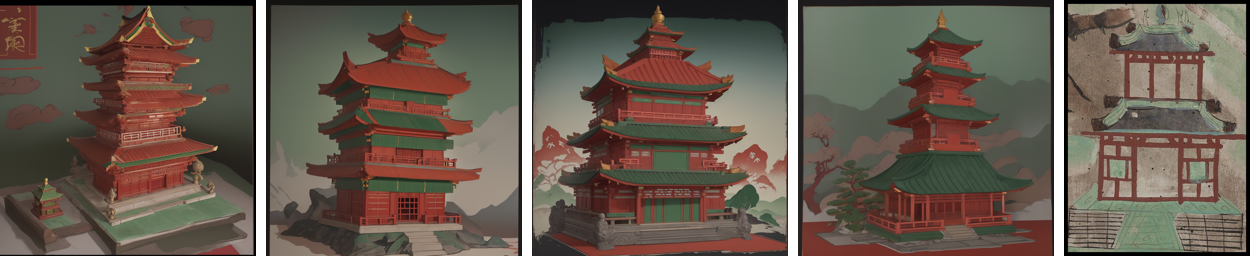

In [27]:
showImgFiles(img_file_list)

In [28]:
sim_idx = selSimImg(input_img_file, img_file_list[:-1])

[0.72010463 0.6891663  0.7414317  0.7223228 ]


In [121]:
img_file_list[sim_idx]

'/work/sz206/SD/api_out/txt2img/txt2img-20240413-225038-1.png'

In [80]:
sim_idx

1

In [81]:
multi_img_sel_files.append(img_file_list[sim_idx])

In [82]:
# comb_img_compare = combImgs([input_img_file, img_file_list[sim_idx]], min_height=256)
# comb_img_compare.save(gen_img_path/"combined_image_comp.jpg")

In [83]:
response = getDescFromGPTVis([input_img_file, img_file_list[sim_idx]], client, diff=True)

In [84]:
diff_desc = response.choices[0].message.content

In [85]:
diff_desc

"The two images depict models of traditional Asian-style buildings, but they differ significantly in their visual presentation and detail:\n\n1. **Material and Texture**:\n   - The first image appears to show a model made of paper or a similarly lightweight material, and the texture is more flat and matte. \n   - The second image features a model that looks like it is made of higher-quality materials, possibly wood, with more detailed and realistic textures, particularly with reflections and shadows that give a more three-dimensional and polished appearance.\n\n2. **Color Scheme**:\n   - The color scheme of the first model is more subdued with faded colors, suggesting either age or the use of less vibrant materials. It has a more vintage or antique look.\n   - The second model uses brighter and more consistent colors, giving it a newer and more vibrant appearance. The green roof tiles and the rich red color of the wooden beams are particularly striking.\n\n3. **Structural Details**:\n 

In [86]:
comb_prompt = combPrompt(orig_desc, diff_desc)

In [87]:
comb_prompt

'Please refine the description of the first image, \n    taking into account the differences identified from the second image created based on this description.\n    the original description is: "The object depicted in the image is a model of a traditional East Asian-style building, resembling a pagoda or a tiered tower commonly found in Chinese and Japanese architecture. This model is intricately designed, capturing the architectural essence with remarkable detail.\n\nThe building features multiple tiers, each adorned with elegant, upward-curving eaves that slope delicately, typical of traditional Asian architecture. These eaves showcase a subdued green color, reminiscent of glazed tiles commonly used in the real-life counterparts. The structure also boasts a beautifully arranged tile pattern on the roof, enhancing its authentic appearance.\n\nThe walls of the building are paneled, with visible vertical and horizontal beams that add a structural aesthetic. In contrast to the white pan

In [88]:
response = getDescFromGPTTxt(client, comb_prompt)

In [90]:
orig_desc = response.choices[0].message.content

In [91]:
orig_desc

'The object depicted in the first image is a model of a traditional East Asian-style building, resembling a pagoda or a tiered tower commonly found in Chinese and Japanese architecture. This model is delicately designed, capturing the architectural essence with remarkable detail.\n\nThe building features multiple tiers, each adorned with elegant, upward-curving eaves that slope delicately, typical of traditional Asian architecture. These eaves showcase a subdued green color, reminiscent of glazed tiles commonly used in the real-life counterparts. The structure also boasts a beautifully arranged tile pattern on the roof, enhancing its authentic appearance.\n\nThe walls of the building are paneled, with visible vertical and horizontal beams that add a structural aesthetic. In contrast to the white panels, the beams are colored in deep red, creating a striking contrast. This color scheme is characteristic of historical East Asian buildings, where red often symbolizes good fortune and joy.